In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

### Zero launch of a function(for NUMBA):

In [2]:
init_shape = (100, 100, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [7]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, _, _ = wrcp.wrcp_als3(
    coo, vals, init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)
rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)
print(rerr)

0.3382081843786568
CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 12.7 ms


### Load the data:

In [8]:
path_data = "Link_Prediction_Data/FB15K237/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

In [9]:
print(entity_list[:3], "\n", len(entity_list))

['J. M. Coetzee', 'Indianapolis', 'Sam Raimi'] 
 14206


In [10]:
print(relation_list[:3], "\n", len(relation_list))

['/sports/pro_athlete/teams./sports/sports_team_roster/team', '/film/film/edited_by', '/people/cause_of_death/people'] 
 235


In [11]:
len(train_triples)

266485

In [12]:
len(valid_triples)

17065

In [13]:
len(test_triples)

19902

In [14]:
list(entity_map.items())[:2]

[('J. M. Coetzee', 0), ('Indianapolis', 1)]

In [15]:
list(relation_map.items())[:2]

[('/sports/pro_athlete/teams./sports/sports_team_roster/team', 0),
 ('/film/film/edited_by', 1)]

### (OPTIONAL)If we want to merge train and valid sets:

In [ ]:
train_triples.extend(valid_triples)

In [ ]:
len(train_triples)

### Create Sparse COO Train Tensor:

In [16]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14206, 235, 14206)

## WRCP-ALS3:

In [17]:
max_iter = 2
rank = 10
l2 = 3e0
seed = 13

In [18]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 53.1 s, sys: 124 ms, total: 53.3 s
Wall time: 53.1 s


In [19]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}")

Relative error = 0.5375245267871568


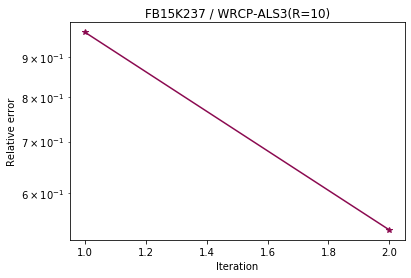

In [21]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15K237 / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

In [22]:
from numba import jit
from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)


@jit(nopython=True)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

@jit(nopython=True)
def hit_rate(train_triples, test_triples, a, b, c,
             how_many=10, iter_show=False, freq=3000):
    
    total = len(test_triples)
    hit = 0
    iteration = 0
    for entity in test_triples:
        iteration += 1
        p = entity[0]
        q = entity[1]
        r = entity[2]

        candidate_values = np.sum(a[p, :] * b[q, :] * c, axis=1)
        candidate_values = sigmoid(candidate_values)
        
        top = np.argsort(candidate_values)[::-1]
        ltop = [i for i in top]
        

        for tr in train_triples:
                
            if (p == tr[0]) and (q == tr[1]):
                if tr[2] == r:
                    print(tr, entity)
                if tr[2] in ltop:
                    ltop.remove(tr[2])
        
        ltop = ltop[:how_many]
        
        for x in ltop:
            if x == r:
                hit += 1
        if iter_show:
            if iteration % freq == 0:
                print(hit / iteration, hit, iteration)
            
    return hit / total, hit, total

hit_rate(
    train_triples[:5],
    test_triples[:5],
    a, b, c, 10,
    iter_show=False,
    freq=3000,
)

(0.2, 1, 5)

In [23]:
%%time
hit_rate(train_triples, test_triples, a, b, c, 10)

CPU times: user 1min 27s, sys: 164 ms, total: 1min 27s
Wall time: 1min 27s


(0.22681137574113155, 4514, 19902)

In [24]:
%%time
hit_rate(train_triples, valid_triples, a, b, c, 10)

CPU times: user 1min 12s, sys: 180 ms, total: 1min 13s
Wall time: 1min 12s


(0.23006152944623498, 3926, 17065)

### Save Factors:

In [31]:
path_factors = "Link_Prediction_Factors/FB15K237/"

pickle.dump(a, open(path_factors + 'A_factor', 'wb'))
pickle.dump(b, open(path_factors + 'B_factor', 'wb'))
pickle.dump(c, open(path_factors + 'C_factor', 'wb'))
pickle.dump(err_arr, open(path_factors + 'Errors', 'wb'))

## Find best parameters:

In [25]:
ranks = (25, 50, 100, 200, 250)
l2 = 3e0
n_iter = 2
seed = 13

In [26]:
table_results = pd.DataFrame(
    np.zeros((len(ranks), 8)),
    index=[i for i in range(1, 6)],
    columns=("iter", "rank", "l2", "time_train", "time_hr", "error", "hr_valid", "hr_test"),
)
table_results

,iter,rank,l2,time_train,time_hr,error,hr_valid,hr_test
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
idx = 0
for rank in track(ranks):
    idx += 1
    # Train model
    start_tr = time.time()
    a, b, c, err_arr, it = wrcp.wrcp_als3(
        coords, values, data_shape,
        rank=rank,
        l2=l2,
        max_iter=n_iter,
        seed=seed,
        show_iter=False,
        it_over=False,
    )
    end_tr = time.time()
            
    # Find relative error
    rerr = sqrt_err_relative(
        coords, values, data_shape, a, b, c,
    )
     
        
    # Find Hit Rate on a validation set
    start_hr = time.time()
    hr_valid, _, _ = hit_rate(train_triples, valid_triples, a, b, c, 10)
    # Find Hit Rate on a test set
    hr_test, _, _ = hit_rate(train_triples, test_triples, a, b, c, 10)
    end_hr = time.time()
            
    table_results.loc[idx]["iter"] = n_iter
    table_results.loc[idx]["rank"] = rank
    table_results.loc[idx]["l2"] = l2
    table_results.loc[idx]["time_train"] = end_tr - start_tr
    table_results.loc[idx]["time_hr"] = end_hr - start_hr
    table_results.loc[idx]["error"] = rerr
    table_results.loc[idx]["hr_valid"] = hr_valid
    table_results.loc[idx]["hr_test"] = hr_test

 [████████████████████████████████████████████████████████████] 5/5 [01:19:19<35:23, 951.90s/it]

In [28]:
table_results

,iter,rank,l2,time_train,time_hr,error,hr_valid,hr_test
1,2.0,25.0,3.0,56.804765,199.792435,0.512390,0.211837,0.207869
2,2.0,50.0,3.0,76.363843,262.310178,0.458913,0.301670,0.295347
3,2.0,100.0,3.0,170.910411,404.303574,0.459383,0.306710,0.305195
4,2.0,200.0,3.0,600.221895,865.149575,0.449931,0.355113,0.351221
5,2.0,250.0,3.0,964.711357,1158.116790,0.458665,0.385292,0.382625


In [29]:
table_results.to_csv("Link_Prediction_Factors/FB15K237/results.csv")

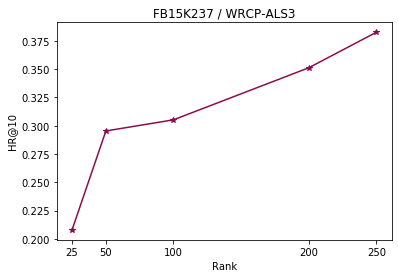

In [30]:
plt.xlabel("Rank")
plt.ylabel("HR@10")
plt.title(f"FB15K237 / WRCP-ALS3")
plt.xticks(table_results['rank'])
#plt.yscale("log")
plt.plot(table_results['rank'], table_results['hr_test'], '-*', c="#8b0a50")

## We can load calculated factors:

In [ ]:
path_factors = "Link_Prediction_Factors/FB15K237/"

a = pickle.load(open(path_factors + 'A_factor', 'rb'))
b = pickle.load(open(path_factors + 'B_factor', 'rb'))
c = pickle.load(open(path_factors + 'C_factor', 'rb'))

In [ ]:
hit_rate(train_triples, test_triples, a, b, c, 10)

In [ ]:
hit_rate(train_triples, valid_triples, a, b, c, 10)